# Определение стоимости автомобиля

**Цели проекта:**
Построить модель, которая будет определять рыночную стоимость автомобиля.

**Описание данных**

**Признаки:**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак:**
- Price — цена (евро)


**План проекта:**
1. Загрузка данных;
2. Изучение данных;
3. Подготовка выборки;
4. Обучение моделей;
5. Сравнение моделей;
6. Выбор лучшей модели;
7. Общие выводы.

In [1]:
# импорт бибилеотек

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings("ignore")
!pip install catboost
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
!pip install phik
from phik import resources
from phik.report import plot_correlation_matrix
from phik import phik_matrix
import time


RANDOM_STATE = 42
TEST_SIZE = 0.25
UNKNOWN_CATEGORY = -1

## Загрузка данных

In [2]:
# чтение данных
try:
    data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Yandex/Determining the cost of cars/autos.csv')
except:
    data = pd.read_csv('/datasets/autos.csv')

In [3]:
# изучение geo_data_0
data.info()
display(data.head())
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [4]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

### Выводы:
1. Данные соответствуют описанию;
2. Среди данных много пропусков в столбцах VehicleType, Gearbox, Model, FuelType, Repaired;
3. В колонках есть аномалии:
    - Price: цена "0";
    - RegistrationYear: год регистрации "1000" и "9999";
    - Power: мощность "0" и "20000";
    - RegistrationMonth: месяцы начинаются с "0";
    - Во всех строках отсутствуют данные о количествах фотографий.
4. Колонки DateCreated и LastSeen необходимо перевести в тип дат.
5. Среди столбцов есть неинформативные: DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, LastSeen. Эти признаки не влияют на стоимость автомобиля.

## Изучение данных

### Удаление неинформативных признаков


In [5]:
# Определение даты выгрузки данных
data['DateCrawled'].max()

'2016-04-07 14:36:58'

In [6]:
data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'LastSeen', 'PostalCode'], axis=1, inplace=True)

### Обработка аномальных значений

#### Price

In [7]:
# исследование данных со значением 0
data[data['Price'] == 0]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,0,NaN,1990,NaN,0,corsa,150000,petrol,opel,NaN
111,0,NaN,2017,manual,0,golf,5000,petrol,volkswagen,NaN
115,0,small,1999,NaN,0,NaN,5000,petrol,volkswagen,NaN
152,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes
...,...,...,...,...,...,...,...,...,...,...
354205,0,NaN,2000,manual,65,corsa,150000,NaN,opel,yes
354238,0,small,2002,manual,60,fiesta,150000,petrol,ford,NaN
354248,0,small,1999,manual,53,swift,150000,petrol,suzuki,NaN
354277,0,small,1999,manual,37,arosa,150000,petrol,seat,yes


Для модели важна точность предсказаний. Среднее значение в колонке может исказить данные.

In [8]:
# удаление значений с аномалией
data = data[data['Price'] > 0]

#### RegistrationYear

In [9]:
# исследование данных со значением меньше 1900
data[data['RegistrationYear'] <= 1900]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
16062,190,NaN,1000,NaN,0,mondeo,5000,NaN,ford,NaN
18224,7999,NaN,1500,manual,224,impreza,5000,NaN,subaru,NaN
34332,450,NaN,1800,NaN,1800,NaN,5000,NaN,mitsubishi,no
38875,1234,NaN,1234,NaN,26,NaN,5000,NaN,trabant,NaN
53577,330,NaN,1000,NaN,0,polo,5000,NaN,volkswagen,NaN
55605,500,NaN,1000,NaN,0,NaN,5000,NaN,citroen,yes
56241,950,NaN,1400,manual,1400,golf,125000,petrol,volkswagen,NaN
60017,80,NaN,1000,NaN,0,NaN,5000,NaN,volkswagen,NaN
66198,1300,NaN,1000,auto,0,NaN,5000,petrol,sonstige_autos,NaN
70847,100,NaN,1255,NaN,0,NaN,5000,NaN,sonstige_autos,NaN


In [10]:
# исследование данных со значением больше 2016
data[data['RegistrationYear'] > 2016]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
22,2900,NaN,2018,manual,90,meriva,150000,petrol,opel,no
26,5555,NaN,2017,manual,125,c4,125000,NaN,citroen,no
48,7750,NaN,2017,manual,80,golf,100000,petrol,volkswagen,NaN
51,2000,NaN,2017,manual,90,punto,150000,gasoline,fiat,yes
57,2399,NaN,2018,manual,64,other,125000,NaN,seat,no
...,...,...,...,...,...,...,...,...,...,...
354112,3600,NaN,2017,manual,86,transit,150000,gasoline,ford,NaN
354140,1000,NaN,2017,manual,101,a4,150000,NaN,audi,NaN
354203,2140,NaN,2018,manual,80,fiesta,150000,NaN,ford,no
354253,1250,NaN,2018,NaN,0,corsa,150000,petrol,opel,NaN


Значений с годом регистрации 1000 и больше 2017 мало. Этими данными можно пренебречь.

In [11]:
# удаление значений с аномалией
data = data[(data['RegistrationYear'] > 1950) & (data['RegistrationYear'] < 2016)]

#### Power

Минимальная мощность двигателя автомобиля 50 л.с. Мощность более 500 для обычного автомобиля слишком высока. Заменим эти значения медианым.

In [12]:
data.loc[(data['Power'] < 50) | (data['Power'] > 500), 'Power'] = data['Power'].median()

### Заполненеи пропусков

In [13]:
data.fillna({'Gearbox':'manual', 'Repaired':'no', 'Model':'unknown'},
                          inplace=True)
data.isna().sum()

Price                   0
VehicleType         11105
RegistrationYear        0
Gearbox                 0
Power                   0
Model                   0
Kilometer               0
FuelType            20702
Brand                   0
Repaired                0
dtype: int64

#### VehicleType

In [14]:
# заменим пропущенные значения самым популярным по группе
data['VehicleType'] = data.groupby('Brand')['VehicleType']\
    .transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan))

#### FuelType

In [15]:
# заменим пропущенные значения самым популярным по группе
data['FuelType'] = data.groupby('Brand')['FuelType']\
    .transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan))

In [16]:
data.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

### Исследование распределения количественных признаков

In [17]:
# Подготовка функции для исследования количественных и дискретных признаков
def viz_num_variable(df, column):
    sns.set(rc={"figure.figsize": (15, 5)})

    # Проверка количества уникальных значений в признаке
    unique_values = df[column].nunique()

    if unique_values <= 15:  # Если количество уникальных значений <= 15, считаем признак дискретным
        sns.countplot(x=df[column], palette='Set2')
        plt.ylabel('Частота')
        plt.xlabel(column)
        plt.title(f'Распределение {column} (дискретный признак)')
    else:  # Иначе считаем признак количественным
        fig, axes = plt.subplots(1, 2)

        sns.histplot(data=df[column], bins=20, ax=axes[0], kde=True)
        axes[0].set(ylabel='Частота', xlabel=column)

        sns.boxplot(x=df[column], ax=axes[1])
        axes[1].set(xlabel=column)

        plt.suptitle(f'Распределение {column} (количественный признак)')

    plt.show()

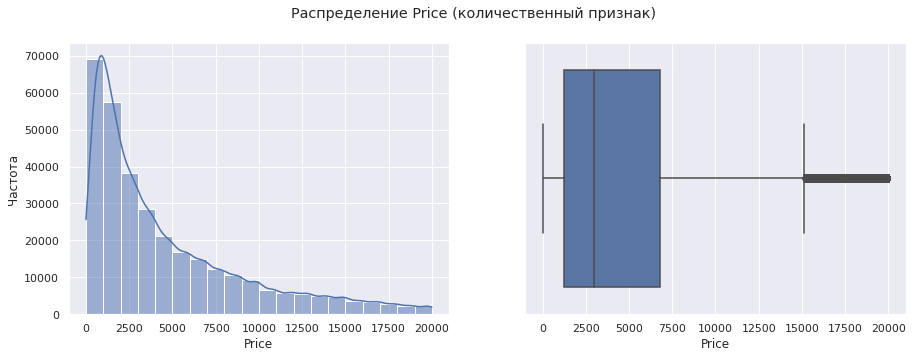

count    320654.000000
mean       4672.257611
std        4562.170992
min           1.000000
25%        1250.000000
50%        2990.000000
75%        6790.000000
max       20000.000000
Name: Price, dtype: float64


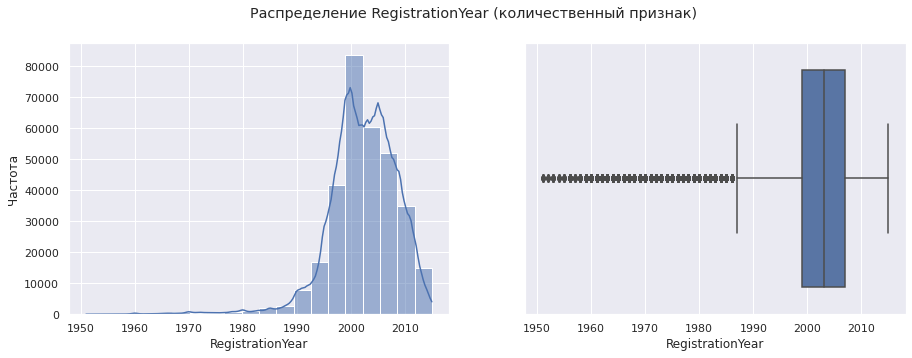

count    320654.000000
mean       2002.251976
std           6.451006
min        1951.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2015.000000
Name: RegistrationYear, dtype: float64


In [18]:
# Исследование количественных и дискретных признаков
for name in data.select_dtypes(include='int64').columns.tolist()[:-1]:
    viz_num_variable(data, name)
    print(data[name].describe())

### Исследование распределения категориальных признаков

In [19]:
# Подготовка функции для исследования категориальных признаков
def viz_cat_variable(df, column, top_n=10):
    sns.set(rc={"figure.figsize": (15, 10)})

    # Проверка количества уникальных значений в признаке
    unique_values = df[column].nunique()

    if unique_values > top_n:
        # Если уникальных значений больше, чем top_n, отбираем топ-N по частоте
        top_values = df[column].value_counts().nlargest(top_n).index
        df_top = df[df[column].isin(top_values)]
        sns.countplot(data=df_top, y=column, order=top_values)
        plt.title(f'Топ-{top_n} значений для {column}')
    else:
        sns.countplot(data=df, y=column)
        plt.title(f'Распределение {column}')

    plt.xlabel('Частота')
    plt.show()

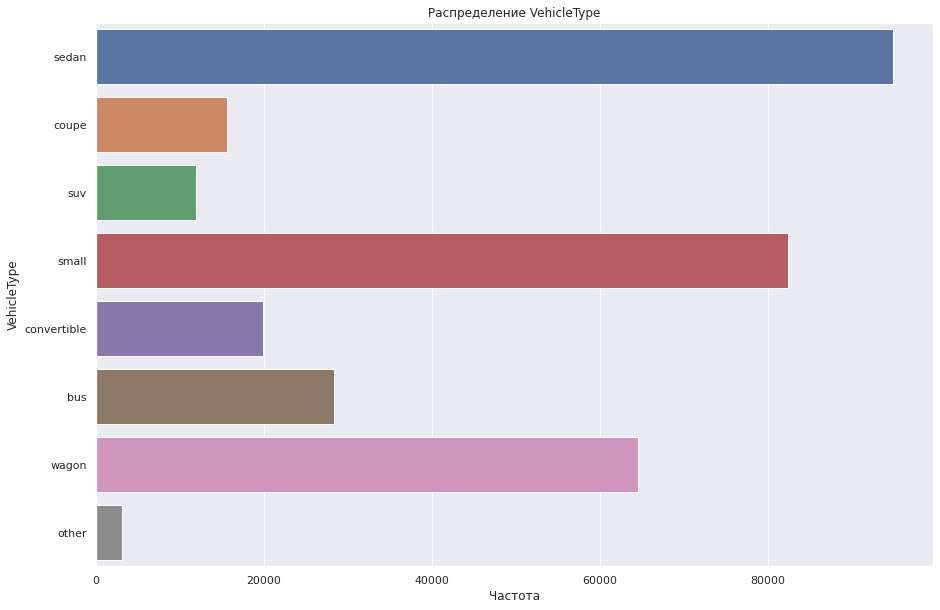

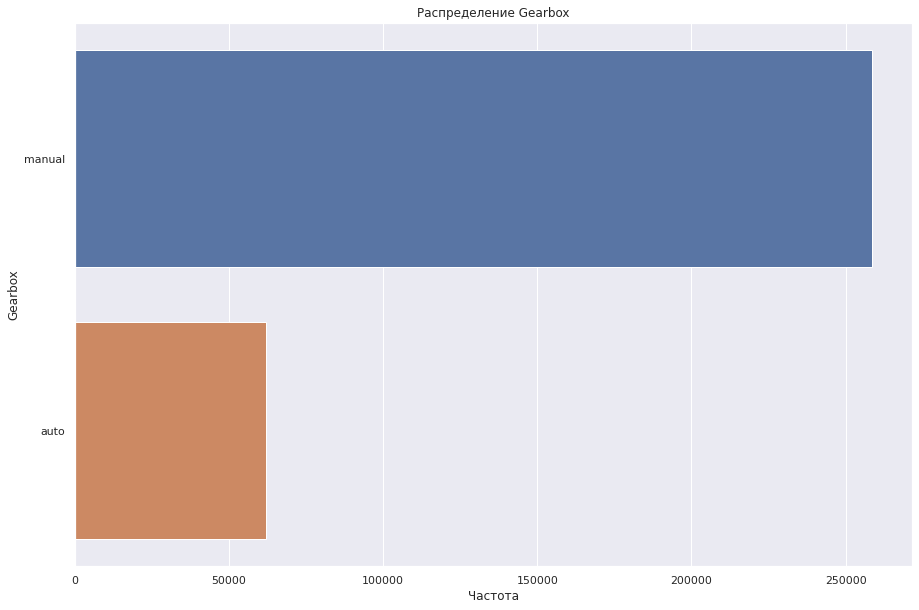

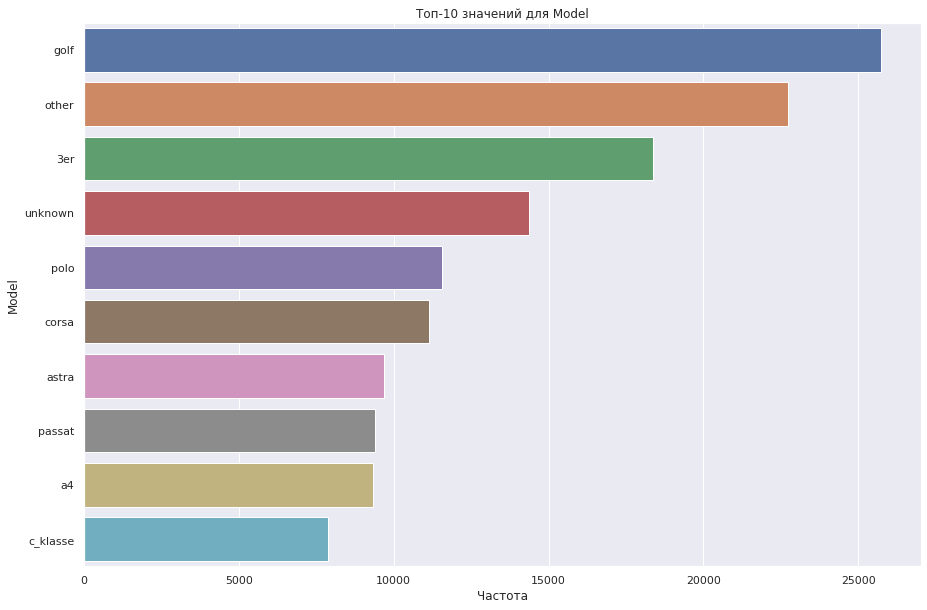

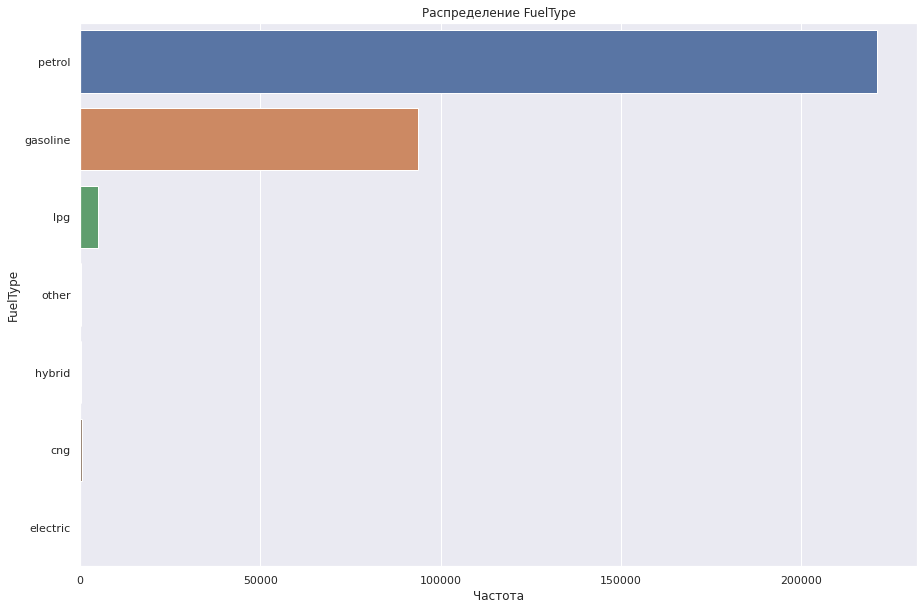

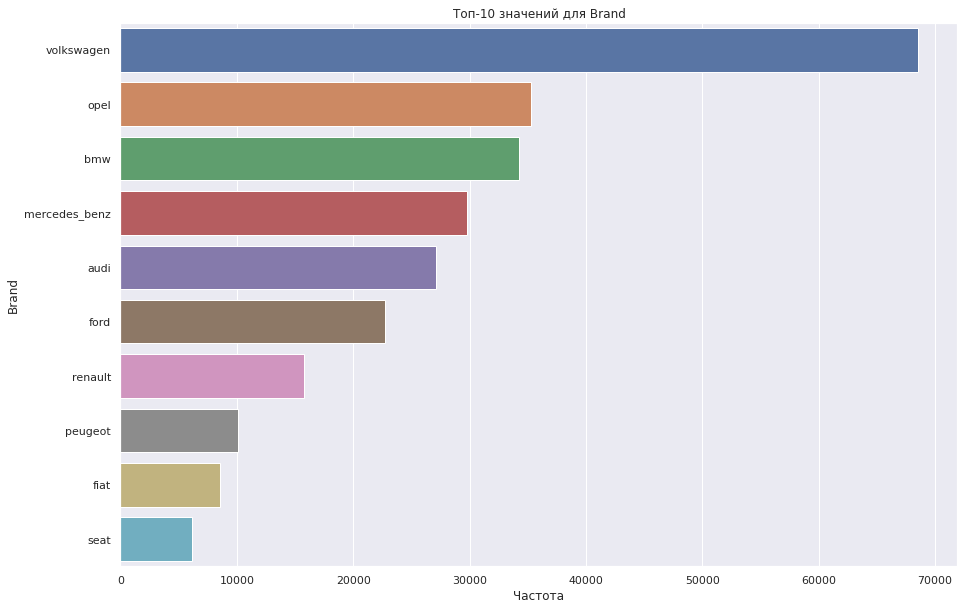

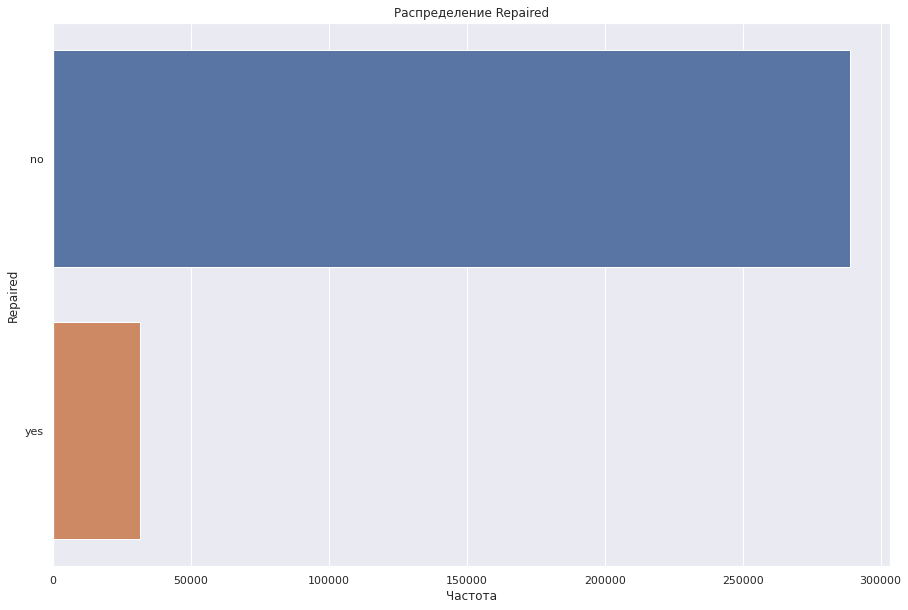

In [20]:
# Исследование категориальных признаков
for name in data.select_dtypes(include='object').columns.tolist():
    viz_cat_variable(data, name, top_n=10)


    AxesSubplot(0.125,0.125;0.775x0.755)


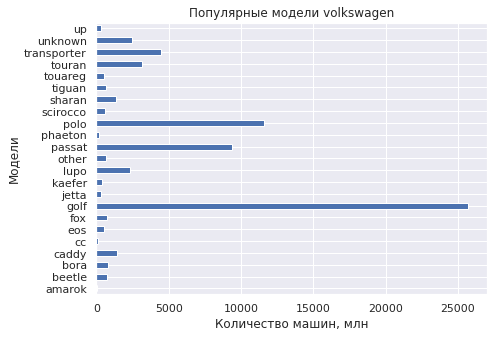


    AxesSubplot(0.125,0.125;0.775x0.755)


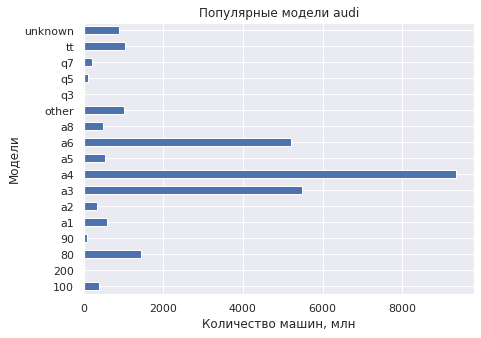


    AxesSubplot(0.125,0.125;0.775x0.755)


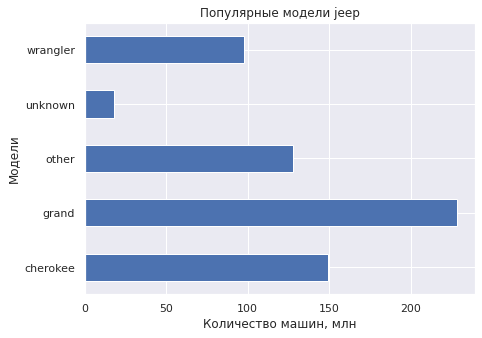


    AxesSubplot(0.125,0.125;0.775x0.755)


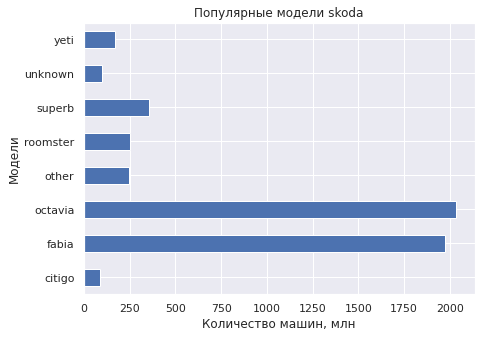


    AxesSubplot(0.125,0.125;0.775x0.755)


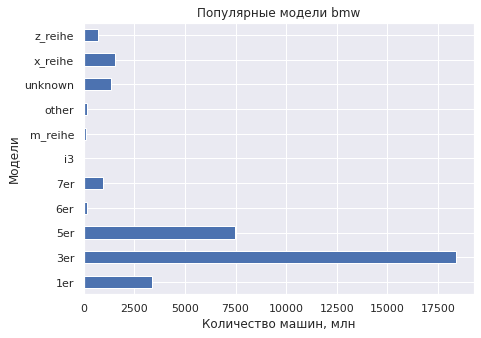


    AxesSubplot(0.125,0.125;0.775x0.755)


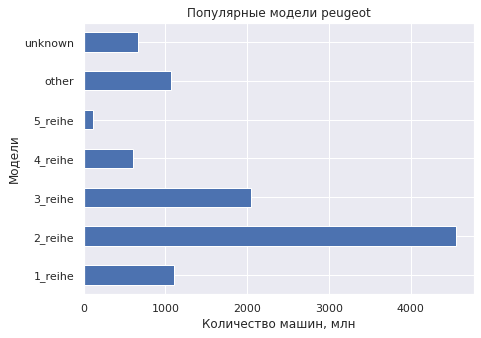


    AxesSubplot(0.125,0.125;0.775x0.755)


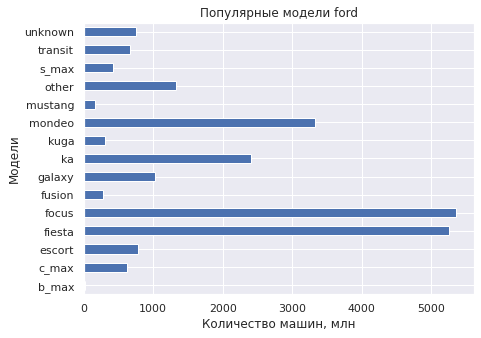


    AxesSubplot(0.125,0.125;0.775x0.755)


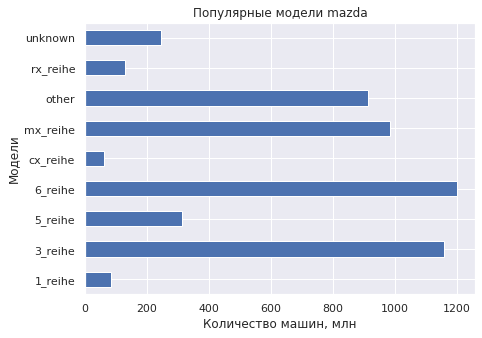


    AxesSubplot(0.125,0.125;0.775x0.755)


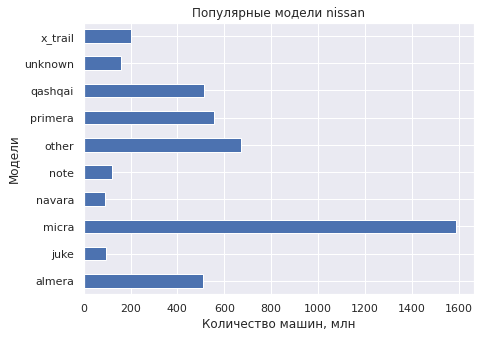


    AxesSubplot(0.125,0.125;0.775x0.755)


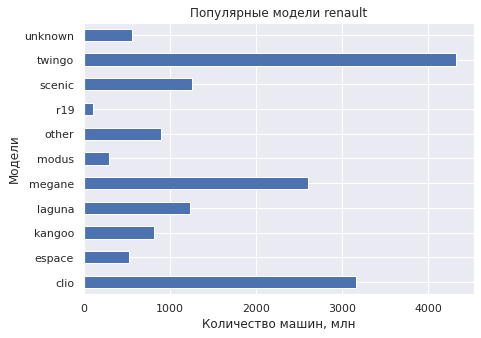


    AxesSubplot(0.125,0.125;0.775x0.755)


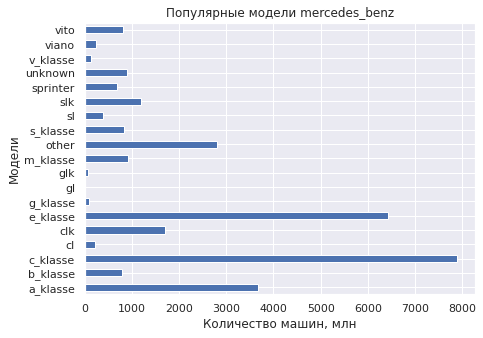


    AxesSubplot(0.125,0.125;0.775x0.755)


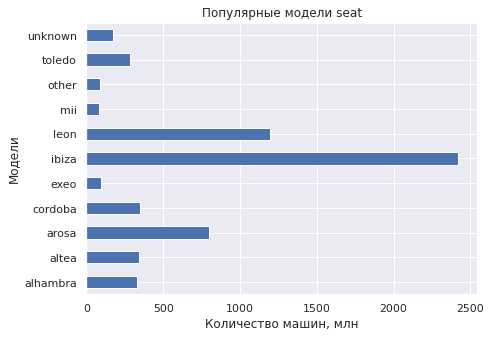


    AxesSubplot(0.125,0.125;0.775x0.755)


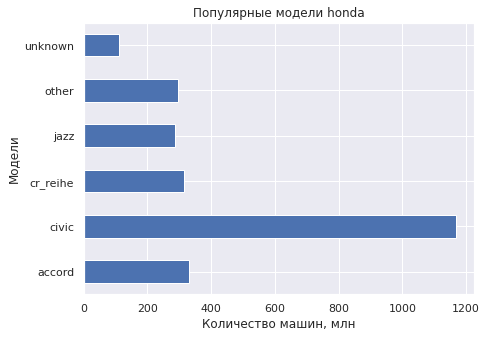


    AxesSubplot(0.125,0.125;0.775x0.755)


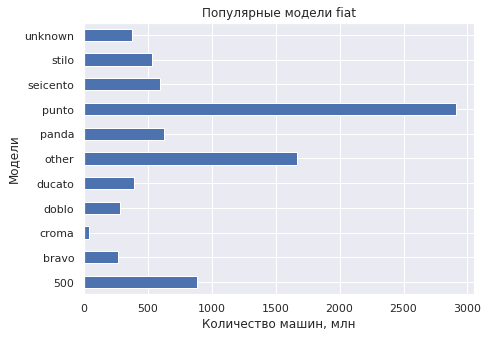


    AxesSubplot(0.125,0.125;0.775x0.755)


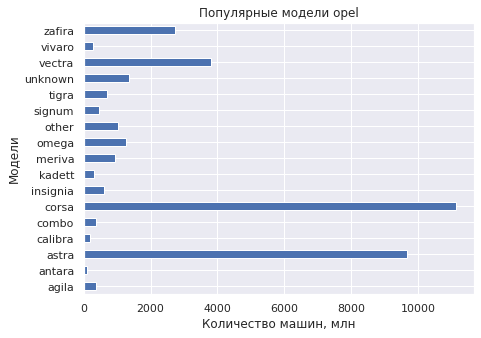


    AxesSubplot(0.125,0.125;0.775x0.755)


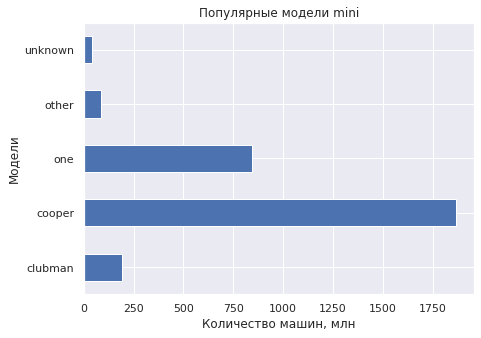


    AxesSubplot(0.125,0.125;0.775x0.755)


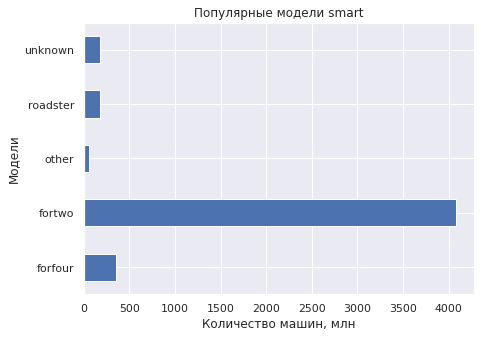


    AxesSubplot(0.125,0.125;0.775x0.755)


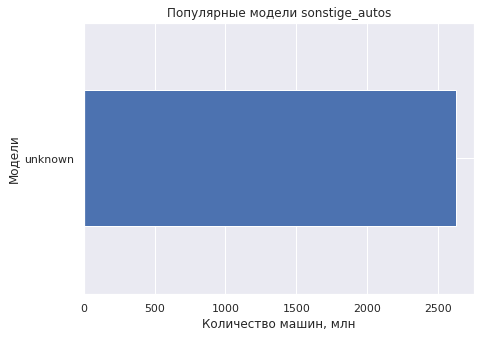


    AxesSubplot(0.125,0.125;0.775x0.755)


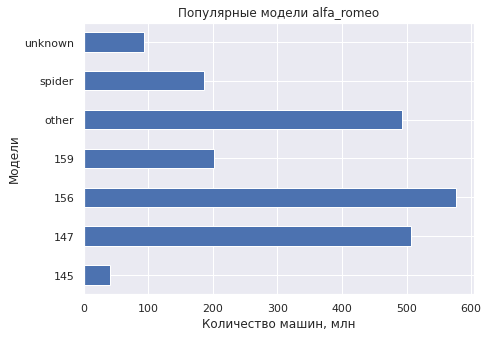


    AxesSubplot(0.125,0.125;0.775x0.755)


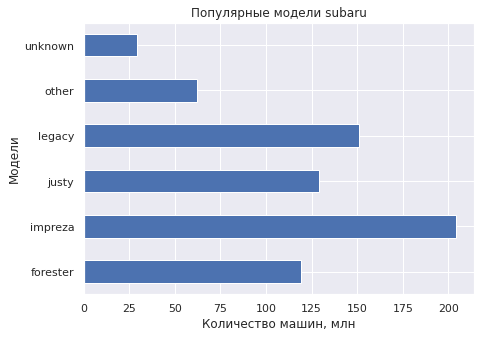


    AxesSubplot(0.125,0.125;0.775x0.755)


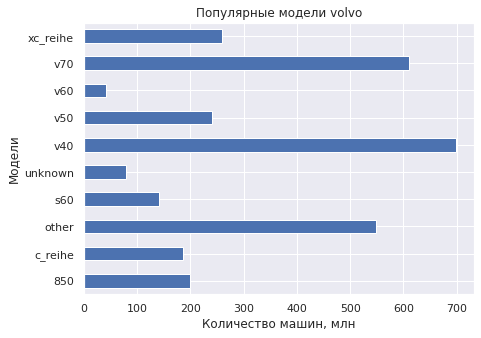


    AxesSubplot(0.125,0.125;0.775x0.755)


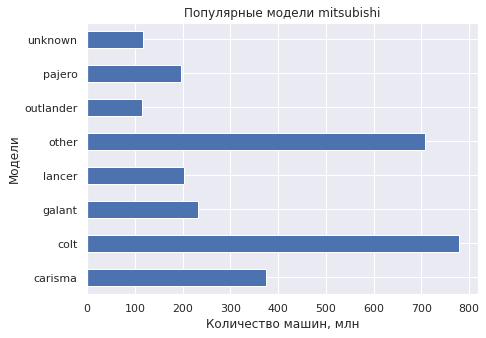


    AxesSubplot(0.125,0.125;0.775x0.755)


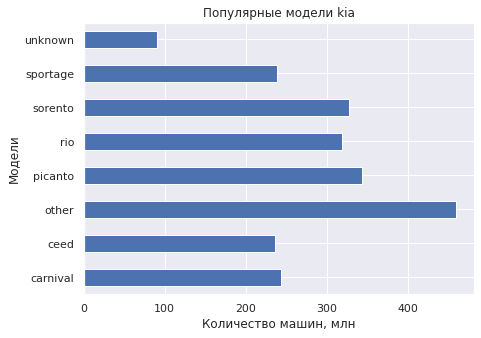


    AxesSubplot(0.125,0.125;0.775x0.755)


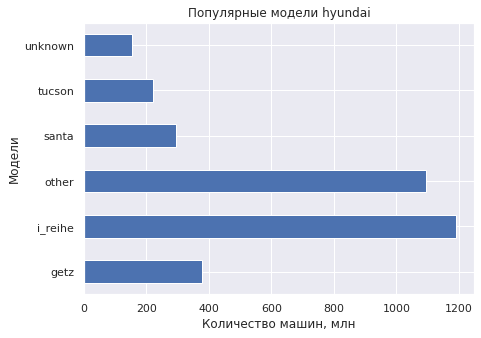


    AxesSubplot(0.125,0.125;0.775x0.755)


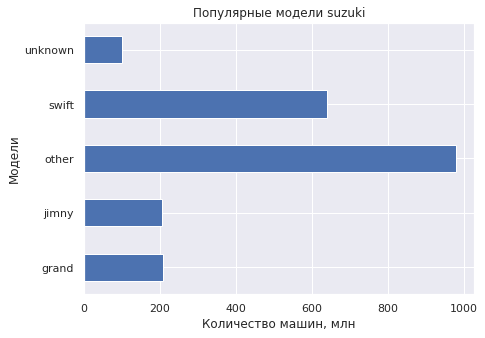


    AxesSubplot(0.125,0.125;0.775x0.755)


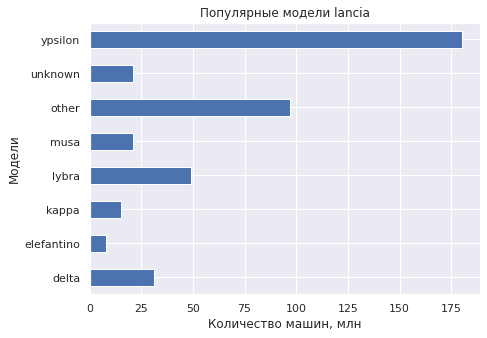


    AxesSubplot(0.125,0.125;0.775x0.755)


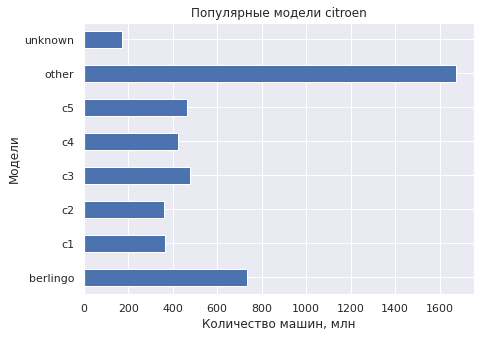


    AxesSubplot(0.125,0.125;0.775x0.755)


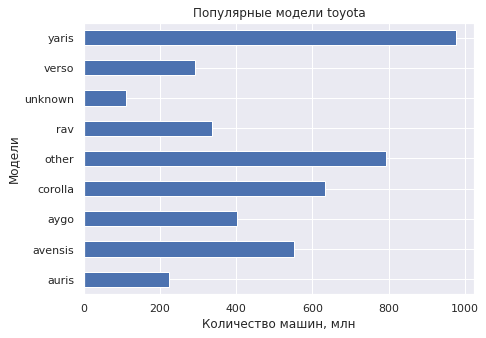


    AxesSubplot(0.125,0.125;0.775x0.755)


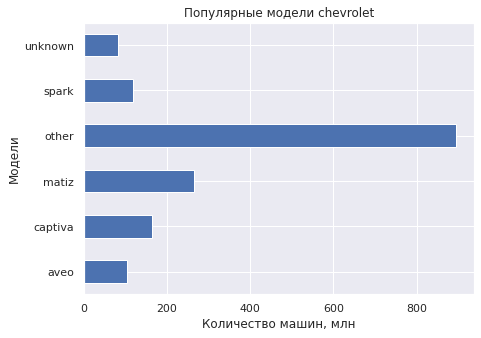


    AxesSubplot(0.125,0.125;0.775x0.755)


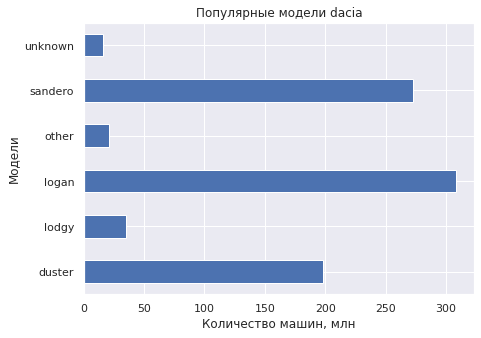


    AxesSubplot(0.125,0.125;0.775x0.755)


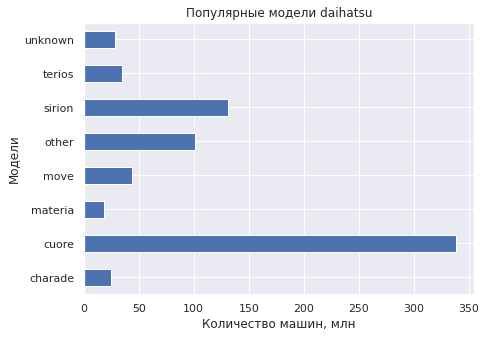


    AxesSubplot(0.125,0.125;0.775x0.755)


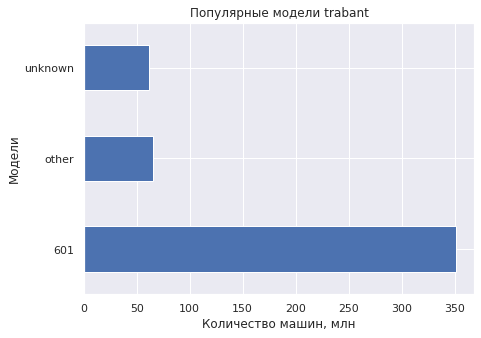


    AxesSubplot(0.125,0.125;0.775x0.755)


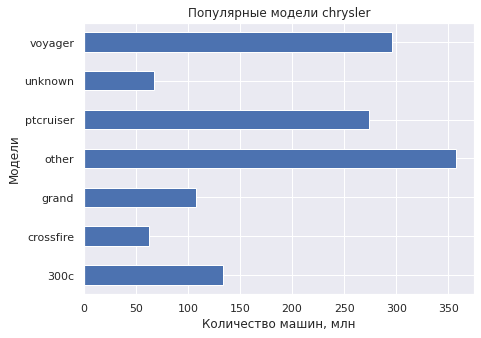


    AxesSubplot(0.125,0.125;0.775x0.755)


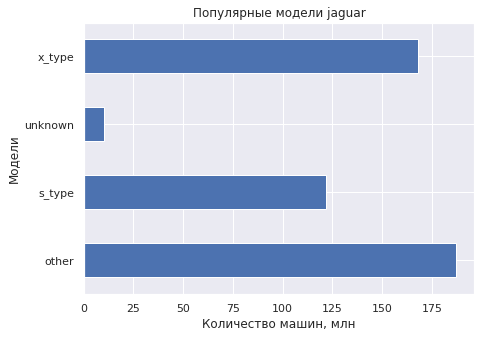


    AxesSubplot(0.125,0.125;0.775x0.755)


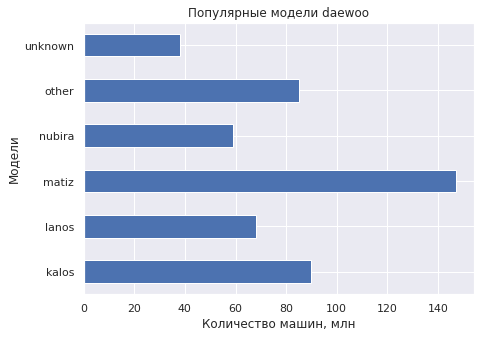


    AxesSubplot(0.125,0.125;0.775x0.755)


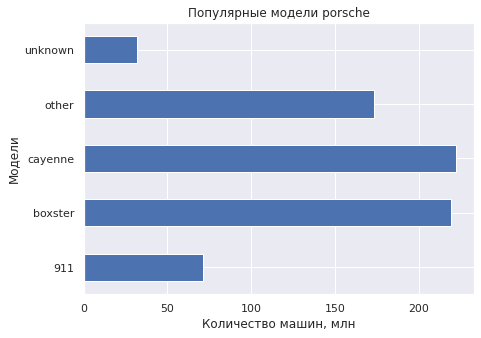


    AxesSubplot(0.125,0.125;0.775x0.755)


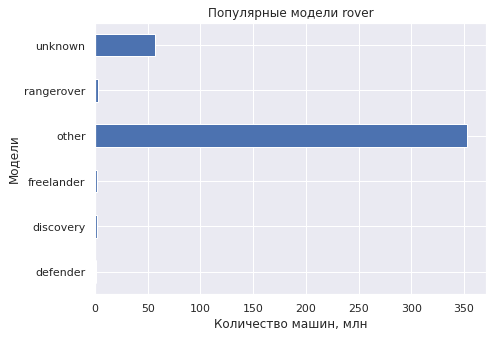


    AxesSubplot(0.125,0.125;0.775x0.755)


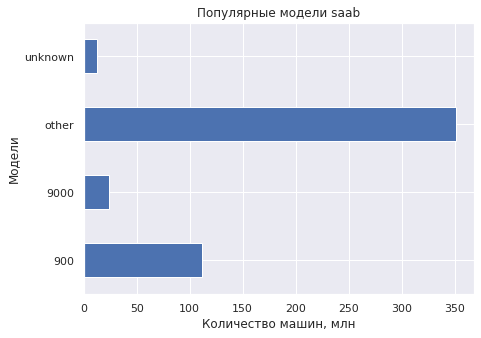


    AxesSubplot(0.125,0.125;0.775x0.755)


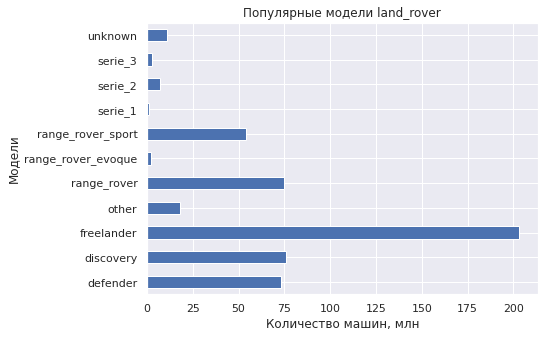


    AxesSubplot(0.125,0.125;0.775x0.755)


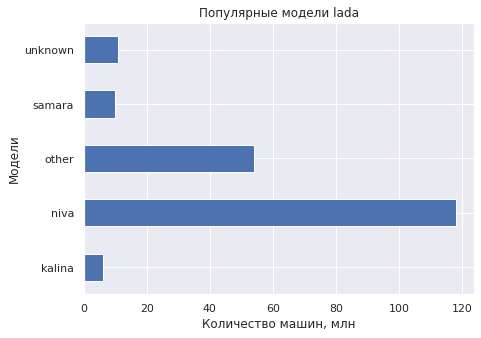

In [21]:
data_brand = data.pivot_table(
    index=('Brand', 'Model'), values='Price', aggfunc='count'
)

for brand in data['Brand'].unique().tolist():
    print(f'''
    {data_brand.loc[brand].plot(
    kind = 'barh',
    figsize = (7,5),
    legend = False
    )}''')
    plt.title(f'Популярные модели {brand}')
    plt.ylabel('Модели')
    plt.xlabel('Количество машин, млн')
    plt.show()

### Корреляционный анализ

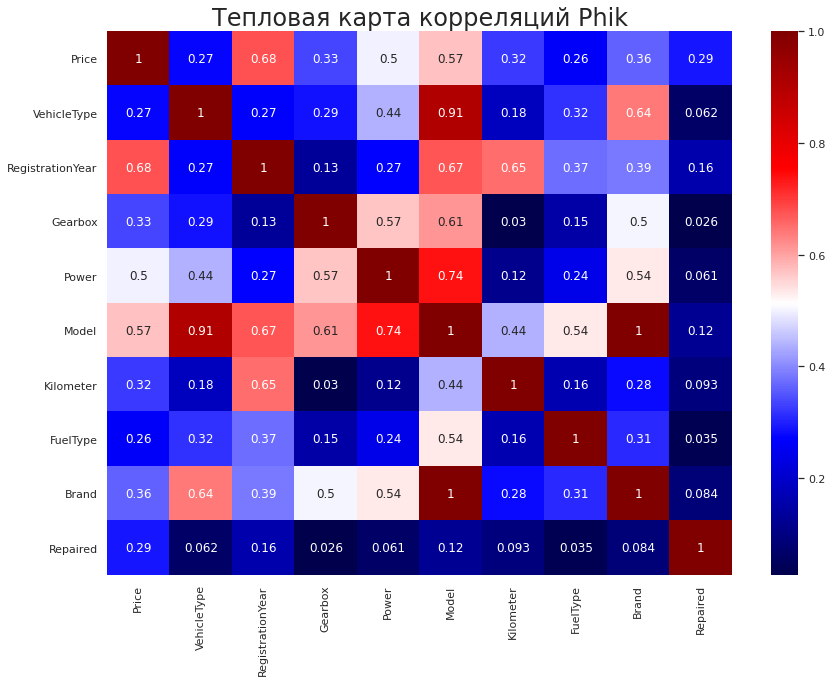

In [22]:
# Определяем числовые признаки (интервальные) за исключением дискретных
interval_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Исключаем дискретные признаки
discrete_cols = ['Kilometer', 'RegistrationYear']
interval_cols = [col for col in interval_cols if col not in discrete_cols]

# Вычисляем матрицу корреляций Phik
phik_corr_matrix = data.phik_matrix(interval_cols=interval_cols)

# Визуализируем матрицу корреляций с помощью sns.heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(phik_corr_matrix, annot=True, cmap='seismic')
plt.title('Тепловая карта корреляций Phik', fontsize=24)
plt.show()

### Выводы:
1. Удалены признаки, которые не влияют напрямую на цену автомобиля
2. Обработаны аномальные значения признаков
3. Исследовано распределение количественных и категориальных признаков
4. Выполнен корреляционный анализ. Наблюдается связь цены с годом регистрации, мощностью и моделью.

## Подготовка выборки

In [23]:
y = data['Price']
X = data.drop(columns=['Price'])

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# Определение категориальных и числовых признаков
cat_columns = X.select_dtypes(include=['object']).columns.tolist()
num_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

## Обучение моделей

### LinearRegression

In [24]:
pipeline_lr = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', RobustScaler(), num_columns),
        ('cat', OneHotEncoder(drop='first'), cat_columns)
    ])),
    ('model', LinearRegression())
])

# Оценка модели с кросс-валидацией
rmse_lr = (cross_val_score(pipeline_lr,
                                X_train,
                                y_train,
                                cv=5,
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression =', rmse_lr)

Mean RMSE from CV of LinearRegression = 2648.4735805527207


### RandomForestRegressor

In [25]:
# Пайплайн для случайного леса
pipeline_rf = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', StandardScaler(), num_columns),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=UNKNOWN_CATEGORY), cat_columns)
    ])),
    ('model', RandomForestRegressor(n_estimators=10,
                                    n_jobs=-1,
                                    random_state=RANDOM_STATE))
])

# Оценка модели с кросс-валидацией
rmse_rf = (cross_val_score(pipeline_rf,
                                X_train,
                                y_train,
                                cv=5,
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of RandomForest =', rmse_rf)

Mean RMSE from CV of RandomForest = 1708.0361660284518


### CatBoostRegressor

In [26]:
# Модель CatBoostRegressor
model_cbr = CatBoostRegressor(learning_rate=0.5,
                              iterations=10,
                              depth=10,
                              random_state=RANDOM_STATE,
                              verbose=False,
                              cat_features=cat_columns)

# Оценка модели с кросс-валидацией
rmse_cbr = (cross_val_score(model_cbr,
                                X_train,
                                y_train,
                                cv=5,
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of CatBoostRegressor =', rmse_cbr)


Mean RMSE from CV of CatBoostRegressor = 1826.333069449387


### LightGBM

In [27]:
X_train_lgbm = X_train.copy()
X_test_lgbm = X_test.copy()

# Преобразование категориальных признаков в тип данных 'category'
for col in cat_columns:
    X_train_lgbm[col] = X_train_lgbm[col].astype('category')
    X_test_lgbm[col] = X_test_lgbm[col].astype('category')

# Инициализация модели с фиксированными параметрами
model_lgbm = LGBMRegressor(
    learning_rate=0.3,
    random_state=42,
    n_jobs=-1,
    verbose=0,
    reg_lambda=0.1,
    min_child_samples=5,
    min_child_weight=1
)

# Гиперпараметры для поиска
hyperparams = {
    'num_leaves': [50, 100],
    'max_depth': [5, 10]
}

# Поиск лучших параметров с помощью GridSearchCV
clf = GridSearchCV(
    model_lgbm,
    hyperparams,
    scoring='neg_mean_squared_error',
    cv=5
)

clf.fit(X_train_lgbm, y_train, categorical_feature=cat_columns)

print("Best parameters set found on development set:")
print(clf.best_params_)

model_lgbm = clf.best_estimator_
rmse_lgbm = (clf.best_score_ * -1) ** 0.5
print('Mean RMSE from CV of LightGBM =', rmse_lgbm)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

## Сравнение моделей

In [28]:
# Функция для измерения времени выполнения кода
def measure_time(func):
    start = time.time()
    result = func()
    end = time.time()
    return result, (end - start) / 60  # возвращаем результат и время в минутах

# Оценка моделей
models_results = {}

### LinearRegression

In [29]:
train_time_lr = measure_time(lambda: pipeline_lr.fit(X_train, y_train))
pred_time_lr = measure_time(lambda: pipeline_lr.predict(X_train))
models_results['LinearRegression'] = {
    'model': pipeline_lr,
    'RMSE': rmse_lr,
    'train_time': train_time_lr[1],
    'pred_time': pred_time_lr[1]}

### RandomForestRegressor

In [30]:
train_time_rf = measure_time(lambda: pipeline_rf.fit(X_train, y_train))
pred_time_rf = measure_time(lambda: pipeline_rf.predict(X_train))
models_results['RandomForestRegressor'] = {
    'model': pipeline_rf,
    'RMSE': rmse_rf,
    'train_time': train_time_rf[1],
    'pred_time': pred_time_rf[1]}

### CatBoostRegressor

In [31]:
train_time_cbr = measure_time(lambda: model_cbr.fit(X_train, y_train))
pred_time_cbr = measure_time(lambda: model_cbr.predict(X_train))
models_results['CatBoostRegressor'] = {
    'model': model_cbr,
    'RMSE': rmse_cbr,
    'train_time': train_time_cbr[1],
    'pred_time': pred_time_cbr[1]}

### LGBM

In [33]:
train_time_lgbm = measure_time(lambda: model_lgbm.fit(X_train_lgbm, y_train))
pred_time_lgbm = measure_time(lambda: model_lgbm.predict(X_train_lgbm))
models_results['LGBMRegressor'] = {
    'model': model_lgbm,
    'RMSE': rmse_lgbm,
    'train_time': train_time_lgbm[1],
    'pred_time': pred_time_lgbm[1]}

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


## Выбор лучшей модели

In [34]:
# Сравнение моделей
def score(model):
    return (
        (model['RMSE'] / min(m['RMSE'] for m in models_results.values())) +
        (model['train_time'] / min(m['train_time'] for m in models_results.values())) +
        (model['pred_time'] / min(m['pred_time'] for m in models_results.values()))
    ) / 3

scores = {k: score(v) for k, v in models_results.items()}

for model, score in scores.items():
    print(f'{model}: {score}')

LinearRegression: 7.299493506649967
RandomForestRegressor: 2.808808631614547
CatBoostRegressor: 1.0445221743772304
LGBMRegressor: 5.240790388883266


In [35]:
# Выбор лучшей модели и тестирование её на тестовой выборке
best_model_name = min(scores, key=scores.get)
best_model = models_results[best_model_name]['model']

# Окончательная оценка на тестовой выборке
predictions, test_time = measure_time(lambda: best_model.predict(X_test))
final_rmse_test = mean_squared_error(y_test, predictions) ** 0.5

print(f'Лучшей моделью оказалась {best_model_name}')
print(f'RMSE на тестовой выборке = {final_rmse_test}')
print(f'Время предсказания на тестовой выборке = {test_time} минут')

Лучшей моделью оказалась CatBoostRegressor
RMSE на тестовой выборке = 1797.9437966143694
Время предсказания на тестовой выборке = 0.0015086849530537923 минут


## Общие выводы


1. **Загрузка и изучение данных:**

    Были загружены данные о машинах, их характеристиках и цене.
    Проведён первоначальный анализ данных: изучены типы данных, выявлены пропуски и аномалии.

2. **Подготовка данных:**

    Произведена очистка данных, включая удаление неинформативных признаков и исправление аномалий в данных.
    В частности, были удалены записи с нулевой стоимостью, исправлены некорректные года регистрации и мощность двигателей.
    Пропущенные значения были заменены наиболее частыми значениями в соответствующих группах данных.

3. **Обучение моделей:**

    Были обучены несколько моделей машинного обучения: LinearRegression, RandomForestRegressor, CatBoostRegressor и LGBMRegressor.
    Модели были обучены на подготовленных данных с последующей оценкой их точности.

4. **Сравнение моделей и выбор лучшей:**

    Проведено сравнение моделей на основе метрики RMSE (Root Mean Squared Error).
    Выбрана модель, показавшая наилучшие результаты, с минимальной ошибкой предсказания.

5. **Итоговые выводы:**

    В результате проведённого анализа и моделирования была выбрана лучшая модель (CatBoostRegressor) с RMSE на тестовой выборке = 1797.94, которая способна определять рыночную стоимость автомобиля на основе его характеристик.
